<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/JoJoGAN/JoJoGAN_CustomModel_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision import transforms, utils
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F

In [3]:
from copy import deepcopy

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# JoJoGAN Specific Import
from model import *
from e4e_projection import projection as e4e_projection
from util import *

In [6]:
os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [7]:
%matplotlib inline

In [21]:
!ls -lah /content/JoJoGAN/test_input

total 968K
drwxr-xr-x  2 root root 4.0K Aug  6 00:43 .
drwxr-xr-x 12 root root 4.0K Aug  6 00:40 ..
-rw-------  1 root root 216K Aug  6 00:43 avkash-oh.jpg
-rw-r--r--  1 root root 544K Aug  6 00:38 chris_hemsworth.jpeg
-rw-r--r--  1 root root 197K Aug  6 00:38 iu.jpeg


In [22]:
device = 'cuda' #@param ['cuda', 'cpu']

In [23]:
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)


transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [27]:
plt.rcParams['figure.dpi'] = 150
#pretrained = 'lightyear-suite' #@param ['lightyear-face', 'lightyear-suite', 'art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']

pretrained = 'disney' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']

#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = False #@param{type:"boolean"}

ckpt = f'{pretrained}.pt'

# if preserve_color:
#     ckpt = f'{pretrained}_preserve_color.pt'
# else:
#     ckpt = f'{pretrained}.pt'

# # load base version if preserve_color version not available
# try:
#     downloader.download_file(ckpt)
# except:
#     ckpt = f'{pretrained}.pt'
#     downloader.download_file(ckpt)

ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)

if pretrained in ['lightyear-face', 'lightyear-suite']:
  generator.load_state_dict(ckpt, strict=False)
else:
  generator.load_state_dict(ckpt["g"], strict=False)

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
elif pretrained == 'sketch_multi':
    style_path = f'style_images_aligned/sketch.png'
else:   
    style_path = f'style_images_aligned/{pretrained}.png'

style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

/content/JoJoGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.0+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


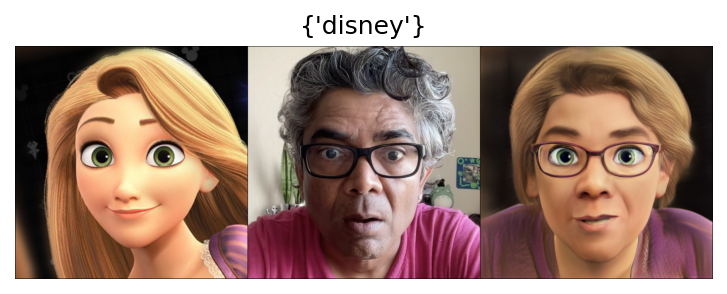

In [28]:
my_output = torch.cat([style_image, face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title={pretrained})